In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import  Dense
from keras.models import Sequential
from keras.optimizers import Adam
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image_dataset_from_directory


2025-04-08 16:37:01.107634: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Definir rutas
base_path = '/prj/posgrad/samuelrt/Documentos/Doutorado/images'
hombres_path = os.path.join(base_path, 'homen')
mujeres_path = os.path.join(base_path, 'mulher')

# Tamaño deseado para las imágenes
img_height, img_width = 128, 128  # Un tamaño más pequeño para reducir dimensionalidad

# Listas para almacenar imágenes y etiquetas
imagenes = []
etiquetas = []

# Cargar imágenes de hombres (etiqueta 0) en escala de grises
for imagen_nombre in os.listdir(hombres_path):
    if imagen_nombre.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(hombres_path, imagen_nombre)
        # Cargar imagen como escala de grises directamente
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Redimensionar
        img = cv2.resize(img, (img_width, img_height))
        # Aplanar la imagen (convertir matriz 2D a vector 1D)
        img_flat = img.flatten()
        imagenes.append(img_flat)
        etiquetas.append(0)  # 0 para hombres

# Cargar imágenes de mujeres (etiqueta 1) en escala de grises
for imagen_nombre in os.listdir(mujeres_path):
    if imagen_nombre.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(mujeres_path, imagen_nombre)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_width, img_height))
        img_flat = img.flatten()
        imagenes.append(img_flat)
        etiquetas.append(1)  # 1 para mujeres

# Convertir listas a arrays de NumPy
X = np.array(imagenes)
y = np.array(etiquetas)

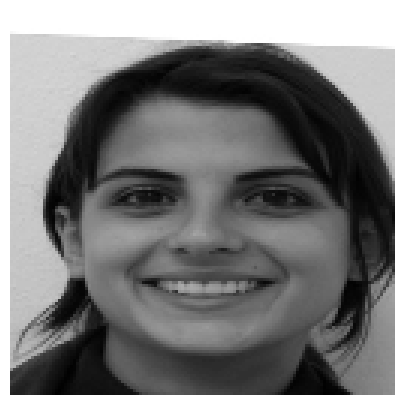

In [7]:
def visualizar_imagen(imagen_flat, altura=64, anchura=64):
    # Reformar el vector aplanado a matriz 2D
    imagen_2d = imagen_flat.reshape(altura, anchura)
    plt.figure(figsize=(5, 5))
    plt.imshow(imagen_2d, cmap='gray')
    plt.axis('off')
    plt.show()

# Para visualizar una imagen del conjunto de entrenamiento
indice = 0  # Cambia el índice para ver diferentes imágenes
visualizar_imagen(X[indice], img_height, img_width)